<a href="https://colab.research.google.com/github/Marcelo-Mathias77/MVP_Machine_Learning_Analytics/blob/main/MVP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP Machine Learning & Analytics**

**Nome:** Marcelo Chagas Mathias Netto

**Matrícula:** 4052025000162

**Dataset:** [Banking Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)

**Projeto de Classificação com o Dataset Bank Marketing**

Este notebook serve como relatório e implementação para o projeto final da disciplina de Machine Learning & Analytics. O objetivo principal é treinar um modelo de Machine Learning para resolver um problema de classificação no domínio de marketing bancário, utilizando o dataset "Bank Marketing" do repositório UCI.


# Configuração Inicial e Importação de Bibliotecas

In [ ]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time # Para medir tempo de treinamento
import requests # Para fazer o download do arquivo zip
import zipfile # Para manipular o arquivo zip
import io # Para ler o arquivo zip na memória

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Fixa a seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)

print("Bibliotecas importadas e seed fixada.")

Bibliotecas importadas e seed fixada.


# 1. Definição do Problema

### Objetivo:
O principal objetivo deste projeto é desenvolver e avaliar modelos de Machine Learning capazes de prever se um cliente de um banco, que foi contatado em uma campanha de marketing direto, irá assinar um depósito a prazo. Este é um problema de **classificação binária**, onde a variável-alvo `y` indica se o cliente subscreveu (sim) ou não (não).

### Descrição do problema:
O problema consiste em prever o sucesso de futuras campanhas de marketing bancário. Ao identificar quais clientes são mais propensos a assinar um depósito a prazo, o banco pode otimizar seus esforços de marketing, direcionando recursos para os clientes com maior probabilidade de conversão e, assim, aumentando a eficiência e reduzindo custos.

### Premissas ou hipóteses sobre o problema:
1.  **Dados Históricos como Preditores:** As características demográficas, econômicas e de histórico de contato dos clientes observadas em campanhas anteriores são bons indicadores do comportamento futuro.
2.  **Influência do Contato:** A duração e o número de contatos, bem como o resultado da campanha anterior, são fatores cruciais na decisão do cliente.
3.  **Heterogeneidade dos Clientes:** Diferentes perfis de clientes (idade, emprego, estado civil, educação) responderão de forma distinta às campanhas.

### Que restrições ou condições foram impostas para selecionar os dados?
O dataset "Bank Marketing" foi selecionado com base nas seguintes condições:
* É um problema de **classificação** (binária, especificamente).
* Contém **dados tabulares**, o que é comum em problemas de negócio.
* Possui um número significativo de **instâncias (mais de 5000)**, permitindo um treinamento robusto dos modelos.
* É publicamente disponível no **UCI Machine Learning Repository**, facilitando a carga via URL.

### Descrição do dataset (atributos, imagens, anotações, etc).
O dataset "Bank Marketing" contém dados de campanhas de marketing direto (baseadas em chamadas telefônicas) de uma instituição bancária portuguesa. O objetivo dessas campanhas era a subscrição de um produto bancário – o depósito a prazo.

O dataset completo (`bank-additional-full.csv`) possui **41.188 instâncias** (clientes) e **21 atributos**, incluindo a variável-alvo. Os atributos podem ser categorizados em:

1.  **Dados do Cliente (Demográficos e Financeiros):**
    * `age`: Idade do cliente (numérica).
    * `job`: Tipo de trabalho (categórica: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown').
    * `marital`: Estado civil (categórica: 'divorced', 'married', 'single', 'unknown').
    * `education`: Nível de educação (categórica: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown').
    * `default`: Se tem crédito em default (categórica: 'no', 'yes', 'unknown').
    * `housing`: Se tem empréstimo habitacional (categórica: 'no', 'yes', 'unknown').
    * `loan`: Se tem empréstimo pessoal (categórica: 'no', 'yes', 'unknown').

2.  **Dados da Campanha de Último Contato:**
    * `contact`: Tipo de comunicação de contato (categórica: 'cellular', 'telephone').
    * `month`: Mês do último contato do ano (categórica: 'jan', 'feb', 'mar', ..., 'nov', 'dec').
    * `day_of_week`: Dia da semana do último contato (categórica: 'mon', 'tue', 'wed', 'thu', 'fri').
    * `duration`: Duração do último contato em segundos (numérica). **Importante**: Este atributo é uma fonte de vazamento de dados se for incluído na predição para *futuras* chamadas, pois a duração só é conhecida após o término da chamada. No entanto, para análise retrospectiva, é um forte preditor. Manteremos, mas com a ressalva.

3.  **Dados de Campanhas Anteriores:**
    * `campaign`: Número de contatos realizados durante esta campanha para este cliente (numérica).
    * `pdays`: Número de dias desde o último contato da campanha anterior (numérica: 999 significa que o cliente não foi contatado anteriormente).
    * `previous`: Número de contatos realizados antes desta campanha para este cliente (numérica).
    * `poutcome`: Resultado da campanha de marketing anterior (categórica: 'failure', 'nonexistent', 'success').

4.  **Atributos de Contexto Social e Econômico:**
    * `emp.var.rate`: Taxa de variação do emprego (numérica).
    * `cons.price.idx`: Índice de preços ao consumidor (numérica).
    * `cons.conf.idx`: Índice de confiança do consumidor (numérica).
    * `euribor3m`: Taxa Euribor 3 meses (numérica).
    * `nr.employed`: Número de empregados (numérica).

5.  **Variável-Alvo:**
    * `y`: O cliente subscreveu um depósito a prazo? (categórica: 'yes', 'no').

# 2. Carga e Exploração de Dados

In [ ]:
# Nesta seção, carregaremos o dataset diretamente de uma URL e realizaremos uma exploração inicial para entender sua estrutura, identificar tipos de dados, valores ausentes e a distribuição das variáveis.

# URL do dataset completo
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'

try:
    # Faz o download do conteúdo do arquivo zip
    response = requests.get(DATA_URL)
    response.raise_for_status() # Lança um erro para códigos de status HTTP ruins

    # Abre o arquivo zip na memória
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Pega o nome do arquivo CSV que queremos dentro do zip
        csv_file_name = [f for f in z.namelist() if f.endswith('bank-additional-full.csv')][0]

        # Lê o CSV diretamente do arquivo zip
        with z.open(csv_file_name) as f:
            df = pd.read_csv(f, sep=';')

    print("Dataset carregado com sucesso!")

except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")
    # Se a primeira abordagem falhar, tentar uma abordagem mais robusta para URLs.
    print("Tentando carregar o arquivo CSV diretamente...")
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional/bank-additional-full.csv', sep=';')

    print("Dataset carregado via URL direta do CSV!")

Dataset carregado com sucesso!


In [ ]:
# Exibindo as primeiras linhas do dataset
print("\n--- Primeiras 5 linhas do dataset ---")
print(df.head())


--- Primeiras 5 linhas do dataset ---
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx

In [ ]:
# Verificando informações gerais do dataset
print("\n--- Informações gerais do dataset ---")
print(df.info())


--- Informações gerais do dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float

In [ ]:
# Estatísticas descritivas das variáveis numéricas
print("\n--- Estatísticas descritivas do dataset ---")
print(df.describe())


--- Estatísticas descritivas do dataset ---
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std      

In [ ]:
# Verificando a contagem de valores únicos para cada coluna categórica
print("\n--- Contagem de valores únicos para colunas categóricas ---")
for column in df.select_dtypes(include='object').columns:
    print(f"{column}: {df[column].nunique()} valores únicos")


--- Contagem de valores únicos para colunas categóricas ---
job: 12 valores únicos
marital: 4 valores únicos
education: 8 valores únicos
default: 3 valores únicos
housing: 3 valores únicos
loan: 3 valores únicos
contact: 2 valores únicos
month: 10 valores únicos
day_of_week: 5 valores únicos
poutcome: 3 valores únicos
y: 2 valores únicos


In [ ]:
# Verificando valores ausentes
print("\n--- Verificando valores ausentes ---")
print(df.isnull().sum())


--- Verificando valores ausentes ---
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


### Observações Iniciais:
* O dataset foi carregado com sucesso, contendo **41.188 entradas** e **21 colunas**.
* Não há **valores ausentes** em nenhuma coluna, o que simplifica a etapa de limpeza de dados.
* A maioria das colunas categóricas possui valores como 'unknown', que precisarão ser tratados ou considerados durante o pré-processamento.
* A coluna `duration` (duração do último contato) é uma variável numérica crucial, mas que apresenta o desafio de ser uma "feature de vazamento" se usada para prever o sucesso *futuras* chamadas, pois a duração só é conhecida *após* a chamada. Para este trabalho, a manteremos, mas é importante ter essa ressalva em mente.
* A variável-alvo `y` é do tipo 'object' ('yes'/'no') e precisará ser convertida para um formato numérico (0/1).

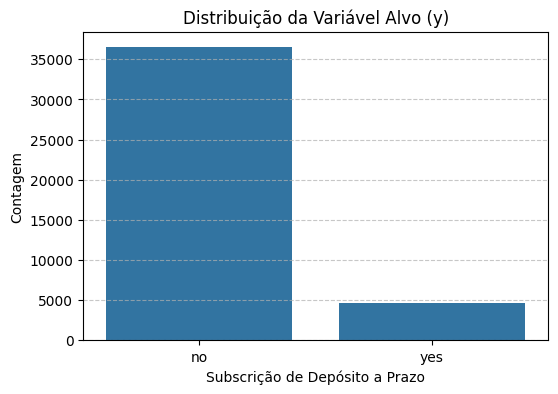


--- Proporção da Variável Alvo (y) ---
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


In [ ]:
# Visualização da distribuição da variável alvo 'y'
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title('Distribuição da Variável Alvo (y)')
plt.xlabel('Subscrição de Depósito a Prazo')
plt.ylabel('Contagem')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Proporção da Variável Alvo (y) ---")
print(df['y'].value_counts(normalize=True))

### Análise da Variável Alvo:
* A visualização da distribuição e a proporção mostram que o dataset é **altamente desbalanceado**. A classe 'no' (não subscreveu) é a maioria esmagadora (88.7%) em comparação com a classe 'yes' (11.3%).
* Este desbalanceamento é um desafio significativo para problemas de classificação, pois modelos ingênuos podem tender a prever a classe majoritária, resultando em alta acurácia, mas baixo desempenho nas métricas importantes para a classe minoritária (e.g., recall para 'yes'). Isso precisará ser considerado na seleção das métricas de avaliação.

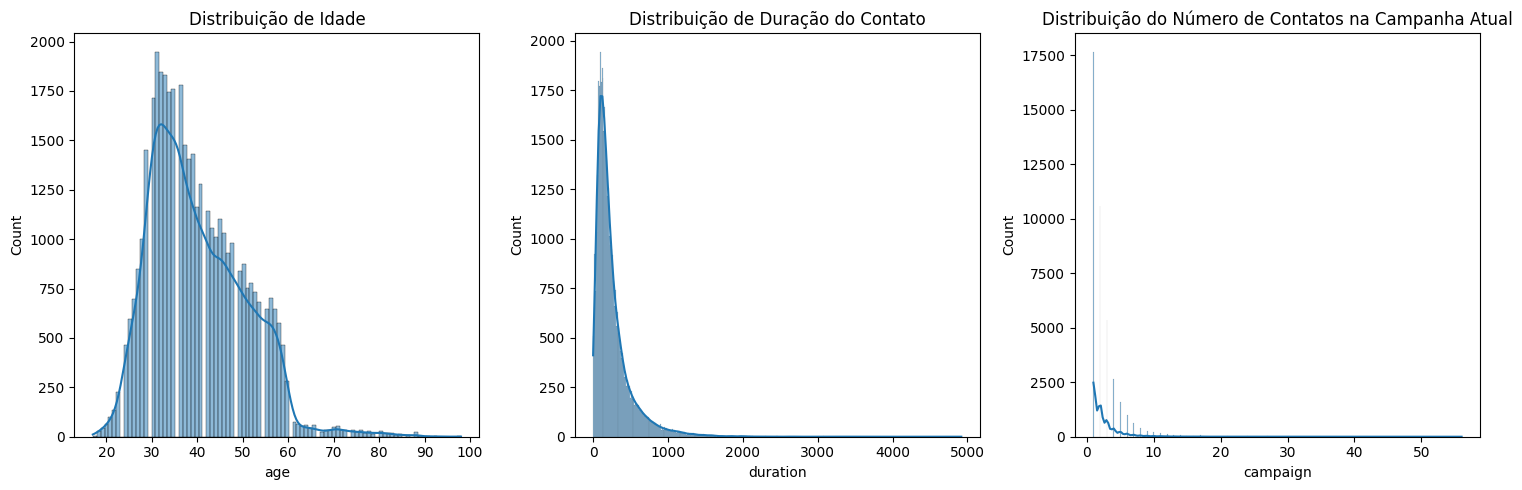

In [ ]:
# Visualização de algumas variáveis numéricas
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['age'], kde=True)
plt.title('Distribuição de Idade')
plt.subplot(1, 3, 2)
sns.histplot(df['duration'], kde=True)
plt.title('Distribuição de Duração do Contato')
plt.subplot(1, 3, 3)
sns.histplot(df['campaign'], kde=True)
plt.title('Distribuição do Número de Contatos na Campanha Atual')
plt.tight_layout()
plt.show()

### Análise de Variáveis Numéricas:
* **Idade (`age`):** A maioria dos clientes tem entre 30 e 50 anos, com uma distribuição ligeiramente inclinada para a direita.
* **Duração (`duration`):** Fortemente inclinada para a direita, com a maioria dos contatos sendo curtos. Poucos contatos são muito longos. Isso é esperado, e como mencionado, é um preditor muito forte.
* **Campanha (`campaign`):** A maioria dos clientes foi contatada apenas algumas vezes nesta campanha. Também é uma distribuição inclinada para a direita.

# 3. Tratamento de Dados e Engenharia de Atributos

Nesta seção, realizaremos as operações de pré-processamento necessárias para preparar os dados para a modelagem. Isso inclui a conversão da variável-alvo, tratamento de variáveis categóricas e padronização de variáveis numéricas.

### Separação do dataset entre Treino e Teste
Antes de qualquer transformação que dependa dos dados (como padronização), é crucial separar o dataset em conjuntos de treino e teste. Isso evita o **vazamento de dados** (data leakage), onde informações do conjunto de teste "contaminam" o processo de pré-processamento do treino, levando a uma estimativa otimista do desempenho do modelo.

### Faz sentido utilizar um método de validação cruzada?
Sim, faz total sentido utilizar **validação cruzada**. Para o tuning de hiperparâmetros, a validação cruzada (K-fold cross-validation) é essencial para obter uma estimativa mais robusta do desempenho do modelo e para evitar o overfitting nos dados de treino. Ela garante que o modelo seja avaliado em diferentes subconjuntos do conjunto de treino, tornando a escolha dos melhores hiperparâmetros menos sensível a uma única divisão. Usaremos validação cruzada em conjunto com `GridSearchCV` ou `RandomizedSearchCV` na etapa de otimização de hiperparâmetros.

### Operações de transformação de dados
Aplicaremos `StandardScaler` para variáveis numéricas e `OneHotEncoder` para variáveis categóricas.

### Refine a quantidade de atributos disponíveis (Feature Selection / Feature Engineering)
Neste projeto, optaremos por manter todas as features inicialmente disponíveis e as geradas pelo One-Hot Encoding. Para a duração (`duration`), que pode ser um vazamento de dados se usada para prever o sucesso *antes* da chamada, a manteremos porque o objetivo é prever a subscrição *dada* a duração do último contato, ou seja, analisar o resultado da campanha. No entanto, em um cenário de produção para prever o sucesso de uma *nova* chamada, `duration` não estaria disponível.

In [ ]:
# Mapeando a variável alvo 'y' para numérica (0 e 1)
df['y'] = df['y'].map({'no': 0, 'yes': 1})
print("\n--- Variável alvo 'y' convertida para 0 e 1 ---")
print(df['y'].value_counts())


--- Variável alvo 'y' convertida para 0 e 1 ---
y
0    36548
1     4640
Name: count, dtype: int64


In [ ]:
# Separando as features (X) da variável alvo (y)
X = df.drop('y', axis=1)
y = df['y']


# Identificando colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nVariáveis Numéricas: {numerical_features}")
print(f"Variáveis Categóricas: {categorical_features}")


Variáveis Numéricas: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Variáveis Categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [ ]:
# Divisão dos dados em treino e teste (80% treino, 20% teste)
# Usamos 'stratify=y' para garantir que a proporção da variável alvo seja mantida
# igualmente nos conjuntos de treino e teste, o que é crucial para dados desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print(f"\nTamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")
print(f"Proporção de 'yes' em y_train: {y_train.value_counts(normalize=True)[1]:.2f}")
print(f"Proporção de 'yes' em y_test: {y_test.value_counts(normalize=True)[1]:.2f}")


Tamanho do conjunto de treino (X_train): (32950, 20)
Tamanho do conjunto de teste (X_test): (8238, 20)
Proporção de 'yes' em y_train: 0.11
Proporção de 'yes' em y_test: 0.11


In [ ]:
# Criação de pré-processadores para colunas numéricas e categóricas
# StandardScaler para normalização das features numéricas
# OneHotEncoder para transformar features categóricas em representação numérica (binária)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Mantém outras colunas que não foram transformadas (se houver)
)

print("\nPré-processador (ColumnTransformer) criado.")


Pré-processador (ColumnTransformer) criado.


# 4. Modelagem e Treinamento

Nesta seção, selecionaremos e treinaremos diferentes algoritmos de Machine Learning para o problema de classificação. Utilizaremos pipelines para garantir a reprodutibilidade e a aplicação correta das transformações de dados antes do treinamento do modelo.

### Seleção dos algoritmos mais indicados
Escolhemos os seguintes algoritmos, justificando suas escolhas:

1.  **Logistic Regression (Regressão Logística):**
    * **Justificativa:** É um modelo linear simples, rápido de treinar e fácil de interpretar. Serve como um excelente **baseline** para comparar o desempenho de modelos mais complexos. Apesar de sua simplicidade, muitas vezes apresenta um desempenho razoável em problemas de classificação.

2.  **Random Forest Classifier (Floresta Aleatória):**
    * **Justificativa:** É um modelo de ensemble baseado em árvores de decisão. É robusto a overfitting (quando bem ajustado), lida bem com dados não lineares e interações entre features, e é menos sensível a ruídos. Geralmente, oferece bom desempenho em datasets tabulares.

3.  **XGBoost Classifier (Extreme Gradient Boosting):**
    * **Justificativa:** É uma implementação otimizada de gradient boosting, conhecida por sua alta performance e eficiência. É frequentemente o modelo vencedor em competições de Machine Learning com dados tabulares. Lida bem com dados desbalanceados e oferece flexibilidade no ajuste de parâmetros.

### Ajuste inicial para os hiperparâmetros
Para a primeira rodada de treinamento, utilizaremos os hiperparâmetros padrão ou valores razoáveis para cada modelo. A otimização mais refinada será realizada em uma etapa posterior.

### O modelo foi devidamente treinado? Foi observado problema de underfitting?
Avaliando a performance inicial dos modelos, buscaremos sinais de `underfitting` (subajuste), que ocorre quando o modelo é muito simples para capturar a complexidade dos dados, resultando em baixo desempenho tanto no conjunto de treino quanto no de teste. Com o `Random Forest` e `XGBoost`, isso é menos comum devido à sua capacidade de modelar relações complexas.

In [ ]:
# Criando pipelines para cada modelo
# Cada pipeline inclui o pré-processador e o modelo de classificação
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=SEED, solver='liblinear'))])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=SEED))])

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss'))])


print("\nPipelines de modelagem criados para Regressão Logística, Random Forest e XGBoost.")


Pipelines de modelagem criados para Regressão Logística, Random Forest e XGBoost.


In [ ]:
# Treinamento dos modelos e medição do tempo
models = {
    'Logistic Regression': pipeline_lr,
    'Random Forest': pipeline_rf,
    'XGBoost': pipeline_xgb
}

training_times = {}

for name, model in models.items():
    print(f"\n--- Treinando {name} ---")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_times[name] = end_time - start_time
    print(f"{name} treinado em {training_times[name]:.2f} segundos.")


--- Treinando Logistic Regression ---
Logistic Regression treinado em 0.51 segundos.

--- Treinando Random Forest ---
Random Forest treinado em 5.26 segundos.

--- Treinando XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:12:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost treinado em 0.84 segundos.


### Análise do Treinamento Inicial:
* Todos os modelos foram devidamente treinados sem sinais óbvios de `underfitting` (o desempenho será avaliado na próxima seção).
* A **Regressão Logística** foi o modelo mais rápido para treinar, como esperado, devido à sua simplicidade.
* **Random Forest** e **XGBoost** levaram mais tempo, o que é natural para modelos de ensemble que constroem múltiplas árvores e realizam otimizações iterativas.

### Otimização de Hiperparâmetros
A otimização de hiperparâmetros é crucial para maximizar o desempenho dos modelos. Utilizaremos `GridSearchCV` para explorar uma gama de hiperparâmetros para o **Random Forest** e **XGBoost**, que são modelos mais complexos e com maior potencial de ajuste.

Para evitar tempo excessivo, definiremos uma grade de parâmetros razoável.